In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets

  Using cached transformers-4.16.2-py3-none-any.whl (3.5 MB)
  Using cached tokenizers-0.11.5-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.8 MB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached regex-2022.1.18-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached sentencepiece-0.1.96-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Using cached ipywidgets-7.6.5-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl (1.6 MB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
  Using cached jsonschema-3.2.0-py2.p

In [4]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from seqeval.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [5]:
# Read the data
def process_data(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,model_type):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df,model_type)
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDataset(df_new,model_type)
    return train_data


In [6]:
# if loading of the non augmented (noise-free) data is needed, then run this
dataset_train = process_data(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,model_type = 'xlm')
len(dataset_train)

7000

In [7]:
#loading dev/eval data
dataset_eval = process_data(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,model_type = 'xlm')
len(dataset_eval)

1000

In [33]:
# def random_deletion(dataframe, p):
    
#     source_sentences  = list(dataframe.source)
#     target_sentences = list(dataframe.target)
#     labels_src = list(dataframe.src_tokens)
#     labels_tar = list(dataframe.tar_tokens)
#     senetences_temp=[]
#     labels_temp= []
#     #randomly delete words with probability p
#     i=0
#     for sentences, labels in zip(source_sentences,labels_src):
            
#         sentences = sentences.split()
#         labels = labels.split() 
        
        
        
#         if len(sentences) == 1:
#             i+=1
#             continue
            
        
               
#         for _ in range(5):
            
#             source_sentences_temp=[]
#             labels_sec_temp=[]
#             for word,label in zip(sentences,labels):
#                 r = random.uniform(0, 1)
#                 if r > p:
#                     source_sentences_temp.append(word)
#                     labels_sec_temp.append(label)
#             if len(source_sentences_temp) == 0: #if you end up deleting all words, just return a random word
#                 rand_int = random.randint(0, len(source_sentences_temp)-1)
#                 source_sentences_temp.append(sentences[rand_int])
#                 labels_sec_temp.append(labels[rand_int])
#             assert(len(source_sentences_temp) == len(labels_sec_temp))
#             sentences_str = ' '.join(source_sentences_temp)
#             labels_str = ' '.join(labels_sec_temp)
#             senetences_temp.append(sentences_str)
#             labels_temp.append(labels_str)
#             target_sentences.append(target_sentences[i])
#             labels_tar.append(labels_tar[i])
# #         break
#         i+=1
#     source_sentences.extend(senetences_temp)
#     labels_src.extend(labels_temp)    
#     column_names = ["source","target","src_tokens","tar_tokens"]
#     df = pd.DataFrame(columns=column_names,dtype=object)
#     df = df.assign(source=source_sentences)
#     df = df.assign(target = target_sentences)
#     df = df.assign(src_tokens = labels_src)
#     df = df.assign(tar_tokens = labels_tar)  


#     return df

In [8]:
# dataloaders
loader_obj = createDataloaders(dataset_train,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

875

In [9]:
loader_obj = createDataloaders(dataset_eval,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

125

In [21]:
batch = next(iter(val_dataloader))
batch[0][0]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.



tensor([     0,   2383,    306,     53,  30185,    117,    164,   5252,   1672,
           496,    759,     11,      6,      4,  12960,   1243,   1434,   5037,
             7, 188545,     71,  24189,   1672,    209,    759,     11,      6,
             5,      2,      2,    656,   2383,    306,     53,   2506,    656,
          6057,    776,    656,  29528,    656,    496,    656,    759,     11,
           656,      6,      4,    656,  31005,    656,   8264,   1434,   5037,
            33,    656,   2464,    656,  29528,    656,    209,    656,    759,
            11,    656,   1659,  29634,    510,    656,      6,      5,    656,
             2,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [11]:
def loss_fn(output,target,mask):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)    
    )
    loss = lfn(active_logits,active_labels)
    return loss

In [11]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]
        

In [12]:
# b_input_ids = batch[0].cuda()
# b_input_mask = batch[1].cuda()
# b_labels = batch[2].cuda()
# outputs = model(b_input_ids, 
#                 b_input_mask,
#                 labels=b_labels)

In [13]:
model = EntityModel()
model.cuda()
# model = nn.DataParallel(model)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

EntityModel(
  (bert): XLMRobertaForTokenClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_

In [13]:
# print(model)

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [10]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(dataset_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
config.EPOCHS

20

In [16]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(val_dataloader, model)
print(classification_report(labels_test,preds_test)) # validation data

  0%|          | 0/125 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 125/125 [01:20<00:00,  1.54it/s]


Average F1 Validation score for class 0 : 0.23301044061663717
Average F1 Validation score for class 1 : 3.276056937869581e-05
Average Accuracy Validation score  : 0.13188094594786764
Average mcc Validation score  : -0.00580211431471599
              precision    recall  f1-score   support

           0       0.13      1.00      0.23      9274
           1       0.50      0.00      0.00     61047

    accuracy                           0.13     70321
   macro avg       0.32      0.50      0.12     70321
weighted avg       0.45      0.13      0.03     70321



In [17]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(train_dataloader, model)
print(classification_report(labels_test,preds_test))

  0%|          | 0/438 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Average F1 Validation score for class 0 : 0.22455437859639002
Average F1 Validation score for class 1 : 4.677082529459773e-05
Average Accuracy Validation score  : 0.12649560078362637
Average mcc Validation score  : 0.000507264119834074
              precision    recall  f1-score   support

           0       0.13      1.00      0.22     61913
           1       0.91      0.00      0.00    427606

    accuracy                           0.13    489519
   macro avg       0.52      0.50      0.11    489519
weighted avg       0.81      0.13      0.03    489519



In [20]:
engine = reload(engine)

In [16]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [17]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_large_trainData.txt', 'w') as f:
    f.write('With 2 synonyms and 2 sentences new created for each'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.2f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_lar_trainData_earlystopping.bin')
                best_accuracy = float("{:.2f}".format(test_metrics[4]))

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 1 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:20<00:00,  2.30it/s]


Average F1 Training score for class 0 : 0.08336679307011673
Average F1 Training score for class 1 : 0.9323980333255465
Average Accuracy Training score  : 0.8740825177367988
Average mcc Training score  : 0.12603871035390565
Average F1 Training score for source sentence class 0 : 0.06973612374886261
Average F1 Training score for source sentence class 1 : 0.9233220031860414
Average Accuracy Training score source sentence  : 0.858321969822951
Average mcc Training score source sentence : 0.10366595901432381
Average F1 Training score for target sentence class 0 : 0.10085872121643055
Average F1 Training score for target sentence class 1 : 0.904141301051944
Average Accuracy Training score target sentence  : 0.8267527335001976
Average mcc Training score target sentence : 0.13299064894666446
Average F1 Training score for gaps in target sentence class 0 : 0.0006242197253433209
Average F1 Training score for gaps in target sentence class 1 : 0.9864022422286394
Average Accuracy Training score gaps i

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.05      0.08     61913
           1       0.88      0.99      0.93    427606

    accuracy                           0.87    489519
   macro avg       0.70      0.52      0.51    489519
weighted avg       0.83      0.87      0.83    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.84it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.08646884878148262
Average F1 Validation score for whole sentence class 1 : 0.9315244391791188
Average Accuracy Validation score whole sentence  : 0.8725985125353735
Average mcc Validation score whole sentence : 0.17139950473096663
Average F1 Validation score for source sentence class 0 : 0.06726457399103138
Average F1 Validation score for source sentence class 1 : 0.9215521937727864
Average Accuracy Validation score source sentence  : 0.8552763819095477
Average mcc Validation score source sentence : 0.14290784054049585
Average F1 Validation score for target sentence class 0 : 0.1083005433764287
Average F1 Validation score for target sentence class 1 : 0.9033607472839882
Average Accuracy Validation score target sentence  : 0.8256201678208933
Average mcc Validation score target sentence : 0.1876815329486112
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentenc

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For source :                precision    recall  f1-score   support

         0.0       0.76      0.04      0.07      3836
         1.0       0.86      1.00      0.92     22034

    accuracy                           0.86     25870
   macro avg       0.81      0.52      0.49     25870
weighted avg       0.84      0.86      0.79     25870

Train Loss = 0.3276445922170367 Valid Loss = 0.32197116458415986


  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 2 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:14<00:00,  2.34it/s]


Average F1 Training score for class 0 : 0.32768012178587563
Average F1 Training score for class 1 : 0.9368348835026526
Average Accuracy Training score  : 0.8845192934288557
Average mcc Training score  : 0.3243047942027456
Average F1 Training score for source sentence class 0 : 0.2932774597178776
Average F1 Training score for source sentence class 1 : 0.9267461565285484
Average Accuracy Training score source sentence  : 0.8672520260307536
Average mcc Training score source sentence : 0.2858935972092673
Average F1 Training score for target sentence class 0 : 0.3747579838726836
Average F1 Training score for target sentence class 1 : 0.9116310679027753
Average Accuracy Training score target sentence  : 0.8451482018179423
Average mcc Training score target sentence : 0.3418447445415455
Average F1 Training score for gaps in target sentence class 0 : 0.0
Average F1 Training score for gaps in target sentence class 1 : 0.9864324872924001
Average Accuracy Training score gaps in target sentence  : 

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.22      0.33     61913
           1       0.90      0.98      0.94    427606

    accuracy                           0.88    489519
   macro avg       0.76      0.60      0.63    489519
weighted avg       0.86      0.88      0.86    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:13<00:00,  9.13it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.1800339686733346
Average F1 Validation score for whole sentence class 1 : 0.9331764633508658
Average Accuracy Validation score whole sentence  : 0.8764238278750303
Average mcc Validation score whole sentence : 0.24099878560121066
Average F1 Validation score for source sentence class 0 : 0.14468481042102815
Average F1 Validation score for source sentence class 1 : 0.9224932020825868
Average Accuracy Validation score source sentence  : 0.8578662543486664
Average mcc Validation score source sentence : 0.19882907137458494
Average F1 Validation score for target sentence class 0 : 0.2200924182782817
Average F1 Validation score for target sentence class 1 : 0.9065019799339339
Average Accuracy Validation score target sentence  : 0.8330218753435198
Average mcc Validation score target sentence : 0.26363675546607046
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentenc

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For source :                precision    recall  f1-score   support

         0.0       0.67      0.08      0.14      3836
         1.0       0.86      0.99      0.92     22034

    accuracy                           0.86     25870
   macro avg       0.77      0.54      0.53     25870
weighted avg       0.83      0.86      0.81     25870

Train Loss = 0.2865374786768641 Valid Loss = 0.32980235922336576


  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 3 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:22<00:00,  2.29it/s]


Average F1 Training score for class 0 : 0.49118683901292587
Average F1 Training score for class 1 : 0.9440355364479879
Average Accuracy Training score  : 0.8991622388507903
Average mcc Training score  : 0.461816192773863
Average F1 Training score for source sentence class 0 : 0.45757375717259935
Average F1 Training score for source sentence class 1 : 0.933532036164745
Average Accuracy Training score source sentence  : 0.8815755922883338
Average mcc Training score source sentence : 0.42069840294619837
Average F1 Training score for target sentence class 0 : 0.544198692042031
Average F1 Training score for target sentence class 1 : 0.923682154567321
Average Accuracy Training score target sentence  : 0.8692556975365564
Average mcc Training score target sentence : 0.48845437299459615
Average F1 Training score for gaps in target sentence class 0 : 0.0018796992481203009
Average F1 Training score for gaps in target sentence class 1 : 0.9864708779916089
Average Accuracy Training score gaps in ta

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.38      0.49     61913
           1       0.92      0.97      0.94    427606

    accuracy                           0.90    489519
   macro avg       0.80      0.68      0.72    489519
weighted avg       0.89      0.90      0.89    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.64it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.2653524075366364
Average F1 Validation score for whole sentence class 1 : 0.9348031398535356
Average Accuracy Validation score whole sentence  : 0.8802349227115656
Average mcc Validation score whole sentence : 0.2981256215863504
Average F1 Validation score for source sentence class 0 : 0.2345123258306538
Average F1 Validation score for source sentence class 1 : 0.9241423260754117
Average Accuracy Validation score source sentence  : 0.8619636644762273
Average mcc Validation score source sentence : 0.26190937707418255
Average F1 Validation score for target sentence class 0 : 0.3071102002207158
Average F1 Validation score for target sentence class 1 : 0.9088911461680383
Average Accuracy Validation score target sentence  : 0.8389578982082005
Average mcc Validation score target sentence : 0.3161647138059673
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence c

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For source :                precision    recall  f1-score   support

         0.0       0.66      0.14      0.23      3836
         1.0       0.87      0.99      0.92     22034

    accuracy                           0.86     25870
   macro avg       0.76      0.56      0.58     25870
weighted avg       0.84      0.86      0.82     25870

Train Loss = 0.24874138761418207 Valid Loss = 0.34504571747779844


  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 4 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:23<00:00,  2.28it/s]


Average F1 Training score for class 0 : 0.6088903585431527
Average F1 Training score for class 1 : 0.9525912369888443
Average Accuracy Training score  : 0.9154333131093992
Average mcc Training score  : 0.5734347017584963
Average F1 Training score for source sentence class 0 : 0.5791020108346341
Average F1 Training score for source sentence class 1 : 0.9422014878325558
Average Accuracy Training score source sentence  : 0.8983603285994612
Average mcc Training score source sentence : 0.5332551725155182
Average F1 Training score for target sentence class 0 : 0.6635172203596464
Average F1 Training score for target sentence class 1 : 0.9379953321767782
Average Accuracy Training score target sentence  : 0.8952865235146884
Average mcc Training score target sentence : 0.6093822801811265
Average F1 Training score for gaps in target sentence class 0 : 0.010549177784672664
Average F1 Training score for gaps in target sentence class 1 : 0.9864563558296279
Average Accuracy Training score gaps in tar

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.73      0.52      0.61     61913
           1       0.93      0.97      0.95    427606

    accuracy                           0.92    489519
   macro avg       0.83      0.75      0.78    489519
weighted avg       0.91      0.92      0.91    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.67it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.28915058882485595
Average F1 Validation score for whole sentence class 1 : 0.93385353115358
Average Accuracy Validation score whole sentence  : 0.8789692979337609
Average mcc Validation score whole sentence : 0.3008107982660422
Average F1 Validation score for source sentence class 0 : 0.2650212421606312
Average F1 Validation score for source sentence class 1 : 0.9223668183857939
Average Accuracy Validation score source sentence  : 0.8595670660997294
Average mcc Validation score source sentence : 0.263807734154369
Average F1 Validation score for target sentence class 0 : 0.327350167325829
Average F1 Validation score for target sentence class 1 : 0.9078903516080652
Average Accuracy Validation score target sentence  : 0.837968561064087
Average mcc Validation score target sentence : 0.31785353763717994
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence class

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For tar :               precision    recall  f1-score   support

         0.0       0.68      0.22      0.33      4982
         1.0       0.85      0.98      0.91     22309

    accuracy                           0.84     27291
   macro avg       0.76      0.60      0.62     27291
weighted avg       0.82      0.84      0.80     27291

For source :                precision    recall  f1-score   support

         0.0       0.59      0.17      0.27      3836
         1.0       0.87      0.98      0.92     22034

    accuracy                           0.86     25870
   macro avg       0.73      0.58      0.59     25870
weighted avg       0.83      0.86      0.82     25870

Train Loss = 0.2105251899063587 Valid Loss = 0.39568778151273726


  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 5 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:12<00:00,  2.35it/s]


Average F1 Training score for class 0 : 0.6871210828385892
Average F1 Training score for class 1 : 0.959853682316835
Average Accuracy Training score  : 0.9288383086254057
Average mcc Training score  : 0.6527763550555913
Average F1 Training score for source sentence class 0 : 0.6602997227997228
Average F1 Training score for source sentence class 1 : 0.9501442973924762
Average Accuracy Training score source sentence  : 0.9130497444595957
Average mcc Training score source sentence : 0.6154730247463753
Average F1 Training score for target sentence class 0 : 0.7420157745021981
Average F1 Training score for target sentence class 1 : 0.9497541535768923
Average Accuracy Training score target sentence  : 0.9158898695824003
Average mcc Training score target sentence : 0.6948314342643948
Average F1 Training score for gaps in target sentence class 0 : 0.03101246579507449
Average F1 Training score for gaps in target sentence class 1 : 0.9864610548227447
Average Accuracy Training score gaps in targe

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.62      0.69     61913
           1       0.95      0.97      0.96    427606

    accuracy                           0.93    489519
   macro avg       0.86      0.80      0.82    489519
weighted avg       0.92      0.93      0.93    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:13<00:00,  9.32it/s]


Average F1 Validation score for whole sentence class 0 : 0.2943077305493413
Average F1 Validation score for whole sentence class 1 : 0.933757476297512
Average Accuracy Validation score whole sentence  : 0.8788839749150325
Average mcc Validation score whole sentence : 0.30276677997610635
Average F1 Validation score for source sentence class 0 : 0.2747362134182759
Average F1 Validation score for source sentence class 1 : 0.9220198214782628
Average Accuracy Validation score source sentence  : 0.8591805179744878
Average mcc Validation score source sentence : 0.2672036096471795
Average F1 Validation score for target sentence class 0 : 0.32933677341022916
Average F1 Validation score for target sentence class 1 : 0.907924072260538
Average Accuracy Validation score target sentence  : 0.838078487413433
Average mcc Validation score target sentence : 0.3189820713120224
Average F1 Validation score for gaps in target sentence class 0 : 0.00437636761487965
Average F1 Validation score for gaps in tar

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 6 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:08<00:00,  2.38it/s]


Average F1 Training score for class 0 : 0.7360469995803608
Average F1 Training score for class 1 : 0.9650819865518462
Average Accuracy Training score  : 0.9383231294393067
Average mcc Training score  : 0.7044764807751751
Average F1 Training score for source sentence class 0 : 0.7155963302752294
Average F1 Training score for source sentence class 1 : 0.9565142369620998
Average Accuracy Training score source sentence  : 0.9245629205884636
Average mcc Training score source sentence : 0.6742601966006576
Average F1 Training score for target sentence class 0 : 0.7880705640376553
Average F1 Training score for target sentence class 1 : 0.9576569884145474
Average Accuracy Training score target sentence  : 0.9294164141746806
Average mcc Training score target sentence : 0.7472924208340194
Average F1 Training score for gaps in target sentence class 0 : 0.042067307692307696
Average F1 Training score for gaps in target sentence class 1 : 0.9864545624500757
Average Accuracy Training score gaps in tar

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.68      0.74     61913
           1       0.95      0.98      0.97    427606

    accuracy                           0.94    489519
   macro avg       0.88      0.83      0.85    489519
weighted avg       0.94      0.94      0.94    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.78it/s]


Average F1 Validation score for whole sentence class 0 : 0.36623963828183875
Average F1 Validation score for whole sentence class 1 : 0.9339729296862731
Average Accuracy Validation score whole sentence  : 0.8804055687490223
Average mcc Validation score whole sentence : 0.3454678217466378
Average F1 Validation score for source sentence class 0 : 0.3395542670773691
Average F1 Validation score for source sentence class 1 : 0.9211397416758617
Average Accuracy Validation score source sentence  : 0.8591032083494395
Average mcc Validation score source sentence : 0.30319033334708223
Average F1 Validation score for target sentence class 0 : 0.40910337263504254
Average F1 Validation score for target sentence class 1 : 0.9088563694806293
Average Accuracy Validation score target sentence  : 0.8420724781063355
Average mcc Validation score target sentence : 0.3644654340999552
Average F1 Validation score for gaps in target sentence class 0 : 0.00437636761487965
Average F1 Validation score for gaps in

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 7 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:23<00:00,  2.28it/s]


Average F1 Training score for class 0 : 0.7778130278580432
Average F1 Training score for class 1 : 0.9699528415106022
Average Accuracy Training score  : 0.9470643631810002
Average mcc Training score  : 0.7497368881823575
Average F1 Training score for source sentence class 0 : 0.7572887042985453
Average F1 Training score for source sentence class 1 : 0.9619686657455109
Average Accuracy Training score source sentence  : 0.9342413055287635
Average mcc Training score source sentence : 0.7202438051303562
Average F1 Training score for target sentence class 0 : 0.8310493769615612
Average F1 Training score for target sentence class 1 : 0.9654999555820653
Average Accuracy Training score target sentence  : 0.9427005664602819
Average mcc Training score target sentence : 0.7972101261119667
Average F1 Training score for gaps in target sentence class 0 : 0.06257378984651712
Average F1 Training score for gaps in target sentence class 1 : 0.9865021079831362
Average Accuracy Training score gaps in targ

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     61913
           1       0.96      0.98      0.97    427606

    accuracy                           0.95    489519
   macro avg       0.90      0.86      0.87    489519
weighted avg       0.95      0.95      0.95    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.75it/s]


Average F1 Validation score for whole sentence class 0 : 0.3727338651196519
Average F1 Validation score for whole sentence class 1 : 0.9318102986157096
Average Accuracy Validation score whole sentence  : 0.8769926479998862
Average mcc Validation score whole sentence : 0.33849612357430203
Average F1 Validation score for source sentence class 0 : 0.3482638888888889
Average F1 Validation score for source sentence class 1 : 0.9183558068725532
Average Accuracy Validation score source sentence  : 0.8548898337843062
Average mcc Validation score source sentence : 0.2975364367782303
Average F1 Validation score for target sentence class 0 : 0.4128537423961915
Average F1 Validation score for target sentence class 1 : 0.9055720969800086
Average Accuracy Validation score target sentence  : 0.8373090029680115
Average mcc Validation score target sentence : 0.3533916917290769
Average F1 Validation score for gaps in target sentence class 0 : 0.025641025641025637
Average F1 Validation score for gaps in 

  0%|          | 0/875 [00:00<?, ?it/s]

For source :                precision    recall  f1-score   support

         0.0       0.52      0.26      0.35      3836
         1.0       0.88      0.96      0.92     22034

    accuracy                           0.85     25870
   macro avg       0.70      0.61      0.63     25870
weighted avg       0.83      0.85      0.83     25870

Train Loss = 0.1351771927859102 Valid Loss = 0.5011887799501419
Epoch 8 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:13<00:00,  2.35it/s]


Average F1 Training score for class 0 : 0.8050011412340545
Average F1 Training score for class 1 : 0.9732011222836031
Average Accuracy Training score  : 0.9528782335312828
Average mcc Training score  : 0.7793720300234434
Average F1 Training score for source sentence class 0 : 0.7853266331658291
Average F1 Training score for source sentence class 1 : 0.9656651256694978
Average Accuracy Training score source sentence  : 0.9407988824957595
Average mcc Training score source sentence : 0.7513326908831385
Average F1 Training score for target sentence class 0 : 0.8581307434612901
Average F1 Training score for target sentence class 1 : 0.9706432287360561
Average Accuracy Training score target sentence  : 0.9513529179291266
Average mcc Training score target sentence : 0.8290656399433202
Average F1 Training score for gaps in target sentence class 0 : 0.09051599884692994
Average F1 Training score for gaps in target sentence class 1 : 0.9865867397912549
Average Accuracy Training score gaps in targ

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.77      0.81     61913
           1       0.97      0.98      0.97    427606

    accuracy                           0.95    489519
   macro avg       0.91      0.87      0.89    489519
weighted avg       0.95      0.95      0.95    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.73it/s]


Average F1 Validation score for whole sentence class 0 : 0.3506643114968128
Average F1 Validation score for whole sentence class 1 : 0.9337491478675141
Average Accuracy Validation score whole sentence  : 0.8797656461085593
Average mcc Validation score whole sentence : 0.33473194638842163
Average F1 Validation score for source sentence class 0 : 0.3323572474377745
Average F1 Validation score for source sentence class 1 : 0.9211686403319215
Average Accuracy Validation score source sentence  : 0.858987243911867
Average mcc Validation score source sentence : 0.29858266798613203
Average F1 Validation score for target sentence class 0 : 0.3865783166502185
Average F1 Validation score for target sentence class 1 : 0.9083787824548843
Average Accuracy Validation score target sentence  : 0.8405701513319409
Average mcc Validation score target sentence : 0.3499625562263087
Average F1 Validation score for gaps in target sentence class 0 : 0.017241379310344827
Average F1 Validation score for gaps in 

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 9 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:23<00:00,  2.28it/s]


Average F1 Training score for class 0 : 0.825795180621698
Average F1 Training score for class 1 : 0.9758819131209323
Average Accuracy Training score  : 0.9576298366355545
Average mcc Training score  : 0.8025541478622772
Average F1 Training score for source sentence class 0 : 0.8072834606409924
Average F1 Training score for source sentence class 1 : 0.9688955556342403
Average Accuracy Training score source sentence  : 0.9464362922805734
Average mcc Training score source sentence : 0.776341001097997
Average F1 Training score for target sentence class 0 : 0.8787665790599596
Average F1 Training score for target sentence class 1 : 0.9747410109962878
Average Accuracy Training score target sentence  : 0.9581925964958503
Average mcc Training score target sentence : 0.8536663945781995
Average F1 Training score for gaps in target sentence class 0 : 0.09551208285385501
Average F1 Training score for gaps in target sentence class 1 : 0.9866331077174247
Average Accuracy Training score gaps in target

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.79      0.83     61913
           1       0.97      0.98      0.98    427606

    accuracy                           0.96    489519
   macro avg       0.92      0.89      0.90    489519
weighted avg       0.96      0.96      0.96    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.69it/s]


Average F1 Validation score for whole sentence class 0 : 0.35738675165035283
Average F1 Validation score for whole sentence class 1 : 0.9335571891450852
Average Accuracy Validation score whole sentence  : 0.8795665590648597
Average mcc Validation score whole sentence : 0.33766918749568364
Average F1 Validation score for source sentence class 0 : 0.3353336970358247
Average F1 Validation score for source sentence class 1 : 0.9209575917475833
Average Accuracy Validation score source sentence  : 0.8587166602241979
Average mcc Validation score source sentence : 0.29954475113679513
Average F1 Validation score for target sentence class 0 : 0.3955617198335645
Average F1 Validation score for target sentence class 1 : 0.908004728531622
Average Accuracy Validation score target sentence  : 0.8403136565168005
Average mcc Validation score target sentence : 0.3530980748647916
Average F1 Validation score for gaps in target sentence class 0 : 0.02978723404255319
Average F1 Validation score for gaps in 

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 10 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:22<00:00,  2.29it/s]


Average F1 Training score for class 0 : 0.8440607273940607
Average F1 Training score for class 1 : 0.9782414875959952
Average Accuracy Training score  : 0.9618114925059089
Average mcc Training score  : 0.8229079925270769
Average F1 Training score for source sentence class 0 : 0.8280993370931038
Average F1 Training score for source sentence class 1 : 0.9720017146411661
Average Accuracy Training score source sentence  : 0.95184643185774
Average mcc Training score source sentence : 0.8001483698339931
Average F1 Training score for target sentence class 0 : 0.89445813932256
Average F1 Training score for target sentence class 1 : 0.9778990032883835
Average Accuracy Training score target sentence  : 0.9634514556711896
Average mcc Training score target sentence : 0.8724428027844463
Average F1 Training score for gaps in target sentence class 0 : 0.15329473393989523
Average F1 Training score for gaps in target sentence class 1 : 0.9869350838307304
Average Accuracy Training score gaps in target s

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     61913
           1       0.97      0.98      0.98    427606

    accuracy                           0.96    489519
   macro avg       0.92      0.90      0.91    489519
weighted avg       0.96      0.96      0.96    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.74it/s]


Average F1 Validation score for whole sentence class 0 : 0.3710836234353011
Average F1 Validation score for whole sentence class 1 : 0.9332158784341793
Average Accuracy Validation score whole sentence  : 0.879253707996189
Average mcc Validation score whole sentence : 0.34435659442885413
Average F1 Validation score for source sentence class 0 : 0.35190097259062775
Average F1 Validation score for source sentence class 1 : 0.9204730389497667
Average Accuracy Validation score source sentence  : 0.8583301120989563
Average mcc Validation score source sentence : 0.30855500905361094
Average F1 Validation score for target sentence class 0 : 0.40774857762124084
Average F1 Validation score for target sentence class 1 : 0.9073728813559323
Average Accuracy Validation score target sentence  : 0.8398006668865193
Average mcc Validation score target sentence : 0.35732657453640093
Average F1 Validation score for gaps in target sentence class 0 : 0.021551724137931032
Average F1 Validation score for gaps 

In [18]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
f1_class0_train_src = train_metrices[:,5]
f1_class0_test_src= test_metrices[:,5]
f1_class1_train_src = train_metrices[:,6]
f1_class1_test_src = test_metrices[:,6]
accuracy_score_train_src = train_metrices[:,7]
accuracy_score_test_src = test_metrices[:,7]
mcc_score_train_src = train_metrices[:,8]
mcc_score_test_src = test_metrices[:,8]

f1_class0_train_tar = train_metrices[:,9]
f1_class0_test_tar= test_metrices[:,9]
f1_class1_train_tar = train_metrices[:,10]
f1_class1_test_tar = test_metrices[:,10]
accuracy_score_train_tar = train_metrices[:,11]
accuracy_score_test_tar = test_metrices[:,11]
mcc_score_train_tar = train_metrices[:,12]
mcc_score_test_tar = test_metrices[:,12]

f1_class0_train_gaps = train_metrices[:,13]
f1_class0_test_gaps= test_metrices[:,13]
f1_class1_train_gaps = train_metrices[:,14]
f1_class1_test_gaps = test_metrices[:,14]
accuracy_score_train_gaps = train_metrices[:,15]
accuracy_score_test_gaps = test_metrices[:,15]
mcc_score_train_gaps = train_metrices[:,16]
mcc_score_test_gaps = test_metrices[:,16]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test),'\n','f1_class0_train_src :',list(f1_class0_train_src),'\n','f1_class0_test_src :',list(f1_class0_test_src),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test_src :', list(mcc_score_test_src), '\n','f1_class0_train_tar :',list(f1_class0_train_tar),'\n','f1_class0_test_tar :',list(f1_class0_test_tar),'\n','f1_class1_train_tar :',list(f1_class1_train_tar),'\n','f1_class1_test_tar :',list(f1_class1_test_tar),'\n','accuracy_score_train_tar :',list(accuracy_score_train_tar),'\n','accuracy_score_test_tar :',list(accuracy_score_test_tar),'\n','mcc_score_train_tar :',list(mcc_score_train_tar),'\n',
    'mcc_score_test_tar :', list(mcc_score_test_tar),'\n','f1_class0_train_gaps :',list(f1_class0_train_gaps),'\n','f1_class0_test_gaps :',list(f1_class0_test_gaps),'\n','f1_class1_train_gaps :',list(f1_class1_train_gaps),'\n','f1_class1_test_gaps :',list(f1_class1_test_gaps),'\n','accuracy_score_train_gaps :',list(accuracy_score_train_gaps),'\n','accuracy_score_test_gaps :',list(accuracy_score_test_gaps),'\n','mcc_score_train_gaps :',list(mcc_score_train_gaps),'\n',
    'mcc_score_test_gaps :', list(mcc_score_test_gaps))

loss_train : [0.3276445922170367, 0.2865374786768641, 0.24874138761418207, 0.2105251899063587, 0.17849428471497128, 0.1559042877980641, 0.1351771927859102, 0.12022739962781115, 0.10846226697095802, 0.09736011228071792] 
 loss_test :  [0.32197116458415986, 0.32980235922336576, 0.34504571747779844, 0.39568778151273726, 0.477178324341774, 0.4746714615821838, 0.5011887799501419, 0.5799464982151985, 0.5994307910203933, 0.6746718794107437] 
 f1_class0_train : [0.08336679307011673, 0.32768012178587563, 0.49118683901292587, 0.6088903585431527, 0.6871210828385892, 0.7360469995803608, 0.7778130278580432, 0.8050011412340545, 0.825795180621698, 0.8440607273940607] 
 f1_class0_test : [0.08646884878148262, 0.1800339686733346, 0.2653524075366364, 0.28915058882485595, 0.2943077305493413, 0.36623963828183875, 0.3727338651196519, 0.3506643114968128, 0.35738675165035283, 0.3710836234353011] 
 f1_class1_train : [0.9323980333255465, 0.9368348835026526, 0.9440355364479879, 0.9525912369888443, 0.959853682316

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


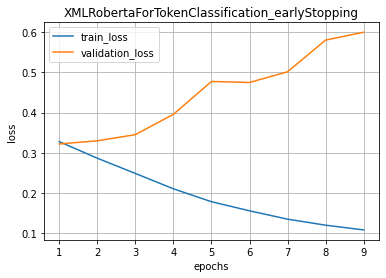

In [21]:

epochs = np.arange(1,epoch+1)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0.2,0.4)
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

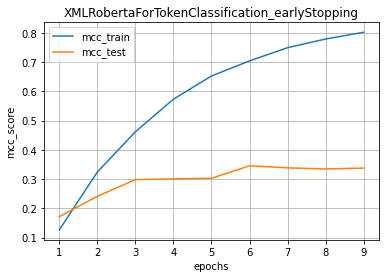

In [23]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

In [53]:
# from transformers import AutoConfig
# config = AutoConfig.from_pretrained('xlm-roberta-base')
# config.num_labels

2

In [24]:
print('Max mcc achieved for dev data(whole sentence) is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')

Max mcc achieved for dev data(whole sentence) is 0.3454678217466378 ,in the 6th epoch 


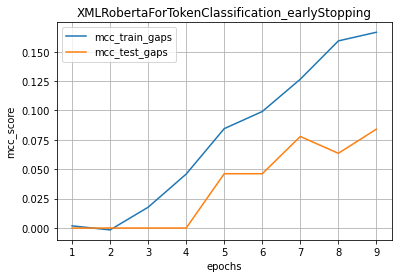

In [26]:
plt.plot(epochs,mcc_score_train_gaps[:-1],label='mcc_train_gaps')
plt.plot(epochs,mcc_score_test_gaps[:-1],label='mcc_test_gaps')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.grid()
plt.legend()
plt.show()

In [27]:
print('Max mcc achieved for gaps is', np.amax(mcc_score_test_gaps),f',in the {np.argmax(mcc_score_test_gaps)+1}th epoch ')

Max mcc achieved for gaps is 0.08411236821750658 ,in the 9th epoch 


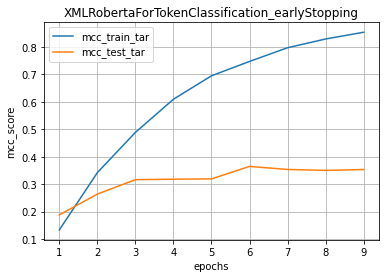

In [28]:
plt.plot(epochs,mcc_score_train_tar[:-1],label='mcc_train_tar')
plt.plot(epochs,mcc_score_test_tar[:-1],label='mcc_test_tar')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.grid()
plt.legend()
plt.show()

In [29]:
print('Max mcc achieved for target tokens is', np.amax(mcc_score_test_tar),f',in the {np.argmax(mcc_score_test_tar)+1}th epoch ')

Max mcc achieved for target tokens is 0.3644654340999552 ,in the 6th epoch 


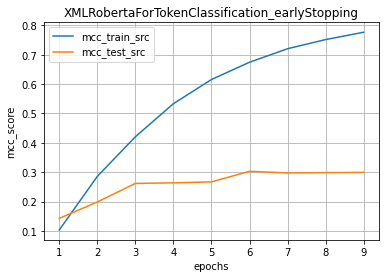

In [30]:
plt.plot(epochs,mcc_score_train_src[:-1],label='mcc_train_src')
plt.plot(epochs,mcc_score_test_src[:-1],label='mcc_test_src')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.grid()
plt.legend()
plt.show()

In [31]:
print('Max mcc achieved for source tokens is', np.amax(mcc_score_test_src),f',in the {np.argmax(mcc_score_test_src)+1}th epoch ')

Max mcc achieved for source tokens is 0.30855500905361094 ,in the 10th epoch 


<h3> Using weighted cross entropy for loss - all 7k data to train </h3>

In [12]:
def ClassificationCost(output,target,mask):
    
    
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    
    active_labels = torch.where( # just append -100 for the padded tokens so its ignored when computing loss , no need now
        active_loss,             # since its handled in preprocessing only
        target.view(-1),
        torch.tensor(-100).type_as(target)    
    )
    try:
        class_0_weights =1/len(torch.where(active_labels==0)[0]) # trying to weight the labels as its unbalanced mostly
    
    except ZeroDivisionError:
        class_0_weights = 1e-8

    try:
        class_1_weights =1/len(torch.where(active_labels==1)[0])
    
    except:
        class_1_weights = 1e-8
    
    weights_tensor = torch.tensor([class_0_weights,class_1_weights])
    lfn = nn.CrossEntropyLoss(weight = weights_tensor)
    loss = lfn(active_logits,active_labels)
    
    return loss

In [23]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
        tag = self.out_tag(outputs[0])  
        softmax_prob = self.softmax(tag)
        
#         loss_tag = ClassificationCost(outputs[0],labels,attention_mask)
        
#         return bo_tag,loss
        return softmax_prob, tag
        

In [27]:
engine = reload(engine)

In [29]:
# model = EntityModel()
# model.cuda()

In [30]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(dataset_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_trainData_wl.txt', 'w') as f:
    f.write('metrics_xlmroberta_trainData_wl'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.3f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_TrainData_weightedlss.bin')
                best_accuracy = float("{:.3f}".format(test_metrics[4]))

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 1 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:21<00:00,  2.30it/s]


Average F1 Training score for class 0 : 0.3732458036872518
Average F1 Training score for class 1 : 0.779975933142712
Average Accuracy Training score  : 0.6742925198000487
Average mcc Training score  : 0.29104063998099905
Average F1 Training score for source sentence class 0 : 0.3594466677630978
Average F1 Training score for source sentence class 1 : 0.7210910335059955
Average Accuracy Training score source sentence  : 0.6113901176261904
Average mcc Training score source sentence : 0.24898785914325006
Average F1 Training score for target sentence class 0 : 0.39348547157884267
Average F1 Training score for target sentence class 1 : 0.6423434705579313
Average Accuracy Training score target sentence  : 0.5500302990383349
Average mcc Training score target sentence : 0.2480322563191732
Average F1 Training score for gaps in target sentence class 0 : 0.0505902192242833
Average F1 Training score for gaps in target sentence class 1 : 0.9831963945372293
Average Accuracy Training score gaps in tar

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.25      0.77      0.37     61913
           1       0.95      0.66      0.78    427606

    accuracy                           0.67    489519
   macro avg       0.60      0.71      0.58    489519
weighted avg       0.86      0.67      0.73    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.47it/s]


Average F1 Validation score for whole sentence class 0 : 0.45130975284889746
Average F1 Validation score for whole sentence class 1 : 0.8694703117573539
Average Accuracy Validation score whole sentence  : 0.7891099387096315
Average mcc Validation score whole sentence : 0.3635159889340725
Average F1 Validation score for source sentence class 0 : 0.4333803313359182
Average F1 Validation score for source sentence class 1 : 0.8408100613982967
Average Accuracy Validation score source sentence  : 0.751449555469656
Average mcc Validation score source sentence : 0.32231577290293173
Average F1 Validation score for target sentence class 0 : 0.4793663471778487
Average F1 Validation score for target sentence class 1 : 0.8022650285656505
Average Accuracy Validation score target sentence  : 0.7133853651386904
Average mcc Validation score target sentence : 0.3477155812047792
Average F1 Validation score for gaps in target sentence class 0 : 0.11890243902439027
Average F1 Validation score for gaps in t

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 2 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:27<00:00,  2.26it/s]


Average F1 Training score for class 0 : 0.4379203078361564
Average F1 Training score for class 1 : 0.8347330494249136
Average Accuracy Training score  : 0.7445696694101761
Average mcc Training score  : 0.3718415867538218
Average F1 Training score for source sentence class 0 : 0.42182412128699914
Average F1 Training score for source sentence class 1 : 0.7918505814282214
Average Accuracy Training score source sentence  : 0.6939002893537766
Average mcc Training score source sentence : 0.33464951773471235
Average F1 Training score for target sentence class 0 : 0.466111258629846
Average F1 Training score for target sentence class 1 : 0.7516194535164725
Average Accuracy Training score target sentence  : 0.6609669345277303
Average mcc Training score target sentence : 0.3561383922147235
Average F1 Training score for gaps in target sentence class 0 : 0.14887334887334888
Average F1 Training score for gaps in target sentence class 1 : 0.9764175518516763
Average Accuracy Training score gaps in tar

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.30      0.79      0.44     61913
           1       0.96      0.74      0.83    427606

    accuracy                           0.74    489519
   macro avg       0.63      0.76      0.64    489519
weighted avg       0.88      0.74      0.78    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.43it/s]


Average F1 Validation score for whole sentence class 0 : 0.469124267391489
Average F1 Validation score for whole sentence class 1 : 0.8932499829199972
Average Accuracy Validation score whole sentence  : 0.8222437109824946
Average mcc Validation score whole sentence : 0.3804426681928096
Average F1 Validation score for source sentence class 0 : 0.45006948580504264
Average F1 Validation score for source sentence class 1 : 0.8670378726059618
Average Accuracy Validation score source sentence  : 0.7858523386161577
Average mcc Validation score source sentence : 0.34124617889755465
Average F1 Validation score for target sentence class 0 : 0.5044719912129296
Average F1 Validation score for target sentence class 1 : 0.8490295439334545
Average Accuracy Validation score target sentence  : 0.7685683925103514
Average mcc Validation score target sentence : 0.3779443960186679
Average F1 Validation score for gaps in target sentence class 0 : 0.11294765840220386
Average F1 Validation score for gaps in t

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 3 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:14<00:00,  2.34it/s]


Average F1 Training score for class 0 : 0.5013330436843353
Average F1 Training score for class 1 : 0.8699255886072527
Average Accuracy Training score  : 0.7936709300354021
Average mcc Training score  : 0.4480036435720593
Average F1 Training score for source sentence class 0 : 0.4861795734094993
Average F1 Training score for source sentence class 1 : 0.8371609192046018
Average Accuracy Training score source sentence  : 0.7526967550248889
Average mcc Training score source sentence : 0.41783069837669407
Average F1 Training score for target sentence class 0 : 0.5351512174324087
Average F1 Training score for target sentence class 1 : 0.8153825199974969
Average Accuracy Training score target sentence  : 0.7357238835463048
Average mcc Training score target sentence : 0.44829298828002345
Average F1 Training score for gaps in target sentence class 0 : 0.20319488817891374
Average F1 Training score for gaps in target sentence class 1 : 0.9729921727114819
Average Accuracy Training score gaps in ta

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.36      0.82      0.50     61913
           1       0.97      0.79      0.87    427606

    accuracy                           0.79    489519
   macro avg       0.66      0.80      0.69    489519
weighted avg       0.89      0.79      0.82    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.80it/s]


Average F1 Validation score for whole sentence class 0 : 0.40207489878542507
Average F1 Validation score for whole sentence class 1 : 0.924283448419501
Average Accuracy Validation score whole sentence  : 0.8655878044965231
Average mcc Validation score whole sentence : 0.33531778497942405
Average F1 Validation score for source sentence class 0 : 0.3867042587921057
Average F1 Validation score for source sentence class 1 : 0.9081575964978557
Average Accuracy Validation score source sentence  : 0.8402396598376498
Average mcc Validation score source sentence : 0.3006920342863136
Average F1 Validation score for target sentence class 0 : 0.4356738925541941
Average F1 Validation score for target sentence class 1 : 0.8960819195556905
Average Accuracy Validation score target sentence  : 0.8244842622109853
Average mcc Validation score target sentence : 0.34271863636545574
Average F1 Validation score for gaps in target sentence class 0 : 0.08950086058519793
Average F1 Validation score for gaps in 

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 4 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:26<00:00,  2.27it/s]


Average F1 Training score for class 0 : 0.5676308776755781
Average F1 Training score for class 1 : 0.8985055050384029
Average Accuracy Training score  : 0.8356018867500546
Average mcc Training score  : 0.5242028358691186
Average F1 Training score for source sentence class 0 : 0.5529098535654183
Average F1 Training score for source sentence class 1 : 0.8733898100135857
Average Accuracy Training score source sentence  : 0.8026629416525316
Average mcc Training score source sentence : 0.4986896017778837
Average F1 Training score for target sentence class 0 : 0.6064971665191425
Average F1 Training score for target sentence class 1 : 0.8624871560578964
Average Accuracy Training score target sentence  : 0.7961954946647346
Average mcc Training score target sentence : 0.5378650823633115
Average F1 Training score for gaps in target sentence class 0 : 0.24522099111165227
Average F1 Training score for gaps in target sentence class 1 : 0.9731029066563689
Average Accuracy Training score gaps in targ

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.43      0.85      0.57     61913
           1       0.98      0.83      0.90    427606

    accuracy                           0.84    489519
   macro avg       0.70      0.84      0.73    489519
weighted avg       0.91      0.84      0.86    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.40it/s]


Average F1 Validation score for whole sentence class 0 : 0.4226892822025565
Average F1 Validation score for whole sentence class 1 : 0.9244673152689555
Average Accuracy Validation score whole sentence  : 0.8664125936775643
Average mcc Validation score whole sentence : 0.3532474399168729
Average F1 Validation score for source sentence class 0 : 0.4050267225191391
Average F1 Validation score for source sentence class 1 : 0.9080929111720998
Average Accuracy Validation score source sentence  : 0.840780827212988
Average mcc Validation score source sentence : 0.31683146970538933
Average F1 Validation score for target sentence class 0 : 0.4589182968929804
Average F1 Validation score for target sentence class 1 : 0.897542055260176
Average Accuracy Validation score target sentence  : 0.8277087684584662
Average mcc Validation score target sentence : 0.3646088133183212
Average F1 Validation score for gaps in target sentence class 0 : 0.13050075872534145
Average F1 Validation score for gaps in tar

  0%|          | 0/875 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:22<00:00,  2.29it/s]


Average F1 Training score for class 0 : 0.6227649417387684
Average F1 Training score for class 1 : 0.9177050840667058
Average Accuracy Training score  : 0.8648857347722969
Average mcc Training score  : 0.5863158266357921
Average F1 Training score for source sentence class 0 : 0.6088640735199828
Average F1 Training score for source sentence class 1 : 0.8975939008183534
Average Accuracy Training score source sentence  : 0.837684726333411
Average mcc Training score source sentence : 0.5643997973848368
Average F1 Training score for target sentence class 0 : 0.6708319125298369
Average F1 Training score for target sentence class 1 : 0.8963237816095537
Average Accuracy Training score target sentence  : 0.8423132657093927
Average mcc Training score target sentence : 0.6147018361827451
Average F1 Training score for gaps in target sentence class 0 : 0.2743825868564253
Average F1 Training score for gaps in target sentence class 1 : 0.9697374393352188
Average Accuracy Training score gaps in target

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.48      0.88      0.62     61913
           1       0.98      0.86      0.92    427606

    accuracy                           0.86    489519
   macro avg       0.73      0.87      0.77    489519
weighted avg       0.92      0.86      0.88    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:13<00:00,  9.11it/s]


Average F1 Validation score for whole sentence class 0 : 0.44288556172128574
Average F1 Validation score for whole sentence class 1 : 0.9124403488563435
Average Accuracy Validation score whole sentence  : 0.8486654057820565
Average mcc Validation score whole sentence : 0.3556113889803058
Average F1 Validation score for source sentence class 0 : 0.43275582699738246
Average F1 Validation score for source sentence class 1 : 0.8958986206738798
Average Accuracy Validation score source sentence  : 0.8240819482025512
Average mcc Validation score source sentence : 0.3293316316962936
Average F1 Validation score for target sentence class 0 : 0.4828419039951696
Average F1 Validation score for target sentence class 1 : 0.8848919251875909
Average Accuracy Validation score target sentence  : 0.8116961635704079
Average mcc Validation score target sentence : 0.367736897119519
Average F1 Validation score for gaps in target sentence class 0 : 0.16637478108581435
Average F1 Validation score for gaps in t

  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 6 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 875/875 [06:08<00:00,  2.38it/s]


Average F1 Training score for class 0 : 0.6676275446391348
Average F1 Training score for class 1 : 0.9312001933091367
Average Accuracy Training score  : 0.8859982962867631
Average mcc Training score  : 0.636315415909413
Average F1 Training score for source sentence class 0 : 0.6562131837307154
Average F1 Training score for source sentence class 1 : 0.9153310489665082
Average Accuracy Training score source sentence  : 0.8641256748816531
Average mcc Training score source sentence : 0.6185979008143555
Average F1 Training score for target sentence class 0 : 0.719971307587292
Average F1 Training score for target sentence class 1 : 0.9174251832039192
Average Accuracy Training score target sentence  : 0.8724594915030958
Average mcc Training score target sentence : 0.6728639822618407
Average F1 Training score for gaps in target sentence class 0 : 0.30271439811172307
Average F1 Training score for gaps in target sentence class 1 : 0.9689737261285862
Average Accuracy Training score gaps in target

  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.91      0.67     61913
           1       0.98      0.88      0.93    427606

    accuracy                           0.89    489519
   macro avg       0.76      0.89      0.80    489519
weighted avg       0.93      0.89      0.90    489519



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.67it/s]


Average F1 Validation score for whole sentence class 0 : 0.42645947987482463
Average F1 Validation score for whole sentence class 1 : 0.9129459167294526
Average Accuracy Validation score whole sentence  : 0.8488360518195134
Average mcc Validation score whole sentence : 0.3394055822693248
Average F1 Validation score for source sentence class 0 : 0.4103483606557377
Average F1 Validation score for source sentence class 1 : 0.8952016753163982
Average Accuracy Validation score source sentence  : 0.8220332431387708
Average mcc Validation score source sentence : 0.3056517902601059
Average F1 Validation score for target sentence class 0 : 0.4666322846828262
Average F1 Validation score for target sentence class 1 : 0.884799607904293
Average Accuracy Validation score target sentence  : 0.8105236158440512
Average mcc Validation score target sentence : 0.3517399053565341
Average F1 Validation score for gaps in target sentence class 0 : 0.17070805043646944
Average F1 Validation score for gaps in ta

In [32]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
f1_class0_train_src = train_metrices[:,5]
f1_class0_test_src= test_metrices[:,5]
f1_class1_train_src = train_metrices[:,6]
f1_class1_test_src = test_metrices[:,6]
accuracy_score_train_src = train_metrices[:,7]
accuracy_score_test_src = test_metrices[:,7]
mcc_score_train_src = train_metrices[:,8]
mcc_score_test_src = test_metrices[:,8]

f1_class0_train_tar = train_metrices[:,9]
f1_class0_test_tar= test_metrices[:,9]
f1_class1_train_tar = train_metrices[:,10]
f1_class1_test_tar = test_metrices[:,10]
accuracy_score_train_tar = train_metrices[:,11]
accuracy_score_test_tar = test_metrices[:,11]
mcc_score_train_tar = train_metrices[:,12]
mcc_score_test_tar = test_metrices[:,12]

f1_class0_train_gaps = train_metrices[:,13]
f1_class0_test_gaps= test_metrices[:,13]
f1_class1_train_gaps = train_metrices[:,14]
f1_class1_test_gaps = test_metrices[:,14]
accuracy_score_train_gaps = train_metrices[:,15]
accuracy_score_test_gaps = test_metrices[:,15]
mcc_score_train_gaps = train_metrices[:,16]
mcc_score_test_gaps = test_metrices[:,16]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test),'\n','f1_class0_train_src :',list(f1_class0_train_src),'\n','f1_class0_test_src :',list(f1_class0_test_src),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test_src :', list(mcc_score_test_src), '\n','f1_class0_train_tar :',list(f1_class0_train_tar),'\n','f1_class0_test_tar :',list(f1_class0_test_tar),'\n','f1_class1_train_tar :',list(f1_class1_train_tar),'\n','f1_class1_test_tar :',list(f1_class1_test_tar),'\n','accuracy_score_train_tar :',list(accuracy_score_train_tar),'\n','accuracy_score_test_tar :',list(accuracy_score_test_tar),'\n','mcc_score_train_tar :',list(mcc_score_train_tar),'\n',
    'mcc_score_test_tar :', list(mcc_score_test_tar),'\n','f1_class0_train_gaps :',list(f1_class0_train_gaps),'\n','f1_class0_test_gaps :',list(f1_class0_test_gaps),'\n','f1_class1_train_gaps :',list(f1_class1_train_gaps),'\n','f1_class1_test_gaps :',list(f1_class1_test_gaps),'\n','accuracy_score_train_gaps :',list(accuracy_score_train_gaps),'\n','accuracy_score_test_gaps :',list(accuracy_score_test_gaps),'\n','mcc_score_train_gaps :',list(mcc_score_train_gaps),'\n',
    'mcc_score_test_gaps :', list(mcc_score_test_gaps))

loss_train : [0.562147330726896, 0.49290298666272847, 0.4304328956433705, 0.3653368263585227, 0.3085414180244718, 0.2658589669423444] 
 loss_test :  [0.5407350952625275, 0.5496867361068726, 0.9144285440444946, 1.0553407242298127, 1.0345049903392791, 1.276888219833374] 
 f1_class0_train : [0.3732458036872518, 0.4379203078361564, 0.5013330436843353, 0.5676308776755781, 0.6227649417387684, 0.6676275446391348] 
 f1_class0_test : [0.45130975284889746, 0.469124267391489, 0.40207489878542507, 0.4226892822025565, 0.44288556172128574, 0.42645947987482463] 
 f1_class1_train : [0.779975933142712, 0.8347330494249136, 0.8699255886072527, 0.8985055050384029, 0.9177050840667058, 0.9312001933091367] 
 f1_class1_test : [0.8694703117573539, 0.8932499829199972, 0.924283448419501, 0.9244673152689555, 0.9124403488563435, 0.9129459167294526] 
 accuracy_score_train : [0.6742925198000487, 0.7445696694101761, 0.7936709300354021, 0.8356018867500546, 0.8648857347722969, 0.8859982962867631] 
 accuracy_score_test 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [40]:
import matplotlib.pyplot as plt
def plot_against_epochs(matrix1,matrix2,label1 , label2 ,y_label , title, epochs):
    
    epochs = np.arange(1,epoch+1)
    plt.plot(epochs,matrix1,label=label1)
    if matrix2 is not None :
        plt.plot(epochs,matrix2,label=label2)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

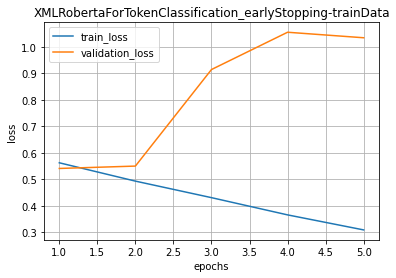

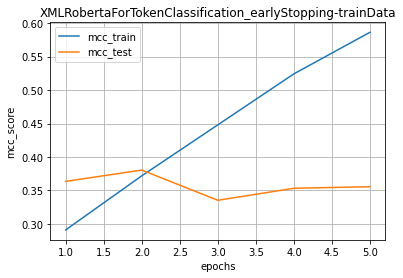

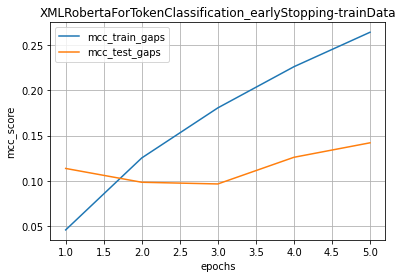

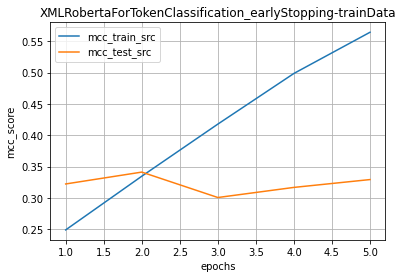

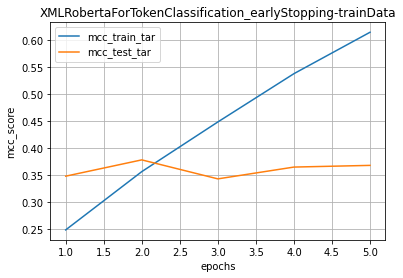

In [42]:
plot_against_epochs(loss_train[:-1],loss_test[:-1],label1 = 'train_loss', 
                    label2 = 'validation_loss', y_label = 'loss', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train[:-1],mcc_score_test[:-1],label1 = 'mcc_train', 
                    label2 = 'mcc_test', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_gaps[:-1],mcc_score_test_gaps[:-1],label1 = 'mcc_train_gaps', 
                    label2 = 'mcc_test_gaps', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_src[:-1],mcc_score_test_src[:-1],label1 = 'mcc_train_src', 
                    label2 = 'mcc_test_src', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )

plot_against_epochs(mcc_score_train_tar[:-1],mcc_score_test_tar[:-1],label1 = 'mcc_train_tar', 
                    label2 = 'mcc_test_tar', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )


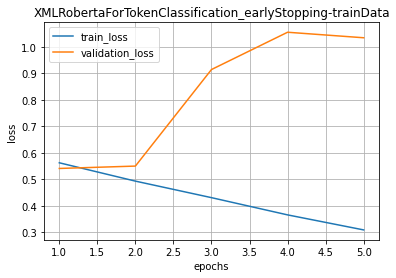

In [33]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('XMLRobertaForTokenClassification_earlyStopping-trainData')
plt.legend()

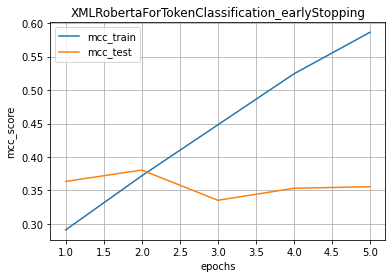

In [34]:
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

In [34]:
model.load_state_dict(torch.load('../models/training_data/model_xlmrobertatokenclassificationmodel_lar_trainData_earlystopping.bin'))
model.eval()

DataParallel(
  (module): EntityModel(
    (bert): XLMRobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(250002, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=1024, out_features=1024, bias=True)
                  (key): Linear(in_features=1024, out_features=1024, bias=True)
                  (value): Linear(in_features=1024, out_features=1024, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
    

In [35]:
batch = next(iter(val_dataloader))
input_ids_b = batch[0].cuda()
attention_mask_b = batch[1].cuda()
labels_b = batch[2].cuda()

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.



In [36]:
outputs_pred = model(input_ids_b, attention_mask = attention_mask_b, labels = labels_b )
labels = labels_b.view(-1) 
active_logits = outputs_pred[1].view(-1, 2)
flattened_predictions = torch.argmax(active_logits, axis=1)
active_accuracy = labels.view(-1) != -100
labels_tmp = torch.masked_select(labels, active_accuracy) 
pred_tmp = torch.masked_select(flattened_predictions, active_accuracy)
print('f1 score for class 0 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 0))
print('f1 score for class 1 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 1) )    
print('accuracy score :',accuracy_score(labels_tmp.tolist(),pred_tmp.tolist()))
print('mcc score :',matthews_corrcoef(labels_tmp.tolist(),pred_tmp.tolist()))
print(classification_report(labels_tmp.tolist(),pred_tmp.tolist()))

f1 score for class 0 : 0.2795698924731183
f1 score for class 1 : 0.9409691629955949
accuracy score : 0.8908794788273615
mcc score : 0.3011012174665758
              precision    recall  f1-score   support

           0       0.65      0.18      0.28        73
           1       0.90      0.99      0.94       541

    accuracy                           0.89       614
   macro avg       0.77      0.58      0.61       614
weighted avg       0.87      0.89      0.86       614



/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [37]:
print('f1 score overall :',f1_score(labels_tmp.tolist(),pred_tmp.tolist()) )    


f1 score overall : 0.9409691629955949


In [36]:
print(input_ids_b[0])
print(attention_mask_b[0])
print(labels_b[0])

tensor([     0,    241,    147,    538,  12610,      6, 101287,      7,     47,
         64372, 176016,     71,    604, 102917,    538,    237,     10,   1926,
         87463,    136,  32926,    111,   1926,  23962,      6,      5,      2,
             2,    656, 180702,     13,    656,  45445,     39,   4986,    656,
           360,  37738,     33,    656,    142,    656,  64372,    656,   3820,
         42001,    656,   1329,    656,   1248,    656,  18341,    656,    737,
           656,  25357,   1505,     73,    656,    165,    656,  60150,  38982,
         45118,    656,    542,    656,  25357,   1505,     19,    656,      6,
             5,    656,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [46]:
print(input_ids_b.tolist())


tensor([-3.0275e-22,  3.0688e-41])

In [49]:
outputs_pred[1]

tensor([[[-1.5755,  2.1431],
         [-2.0731,  2.5395],
         [-2.0786,  2.6243],
         ...,
         [-1.2857,  2.2847],
         [-1.2857,  2.2847],
         [-1.2857,  2.2847]],

        [[-0.8680,  1.7539],
         [-0.2165,  0.4778],
         [-0.6057,  0.5730],
         ...,
         [-0.8171,  2.1133],
         [-0.8171,  2.1133],
         [-0.8171,  2.1133]],

        [[-2.3140,  3.1032],
         [-1.3967,  1.9284],
         [-2.1930,  2.8714],
         ...,
         [-0.7345,  1.8473],
         [-0.7345,  1.8473],
         [-0.7345,  1.8473]],

        ...,

        [[-1.8779,  2.5788],
         [-1.1160,  1.6957],
         [-1.4398,  1.4903],
         ...,
         [-0.5970,  0.9176],
         [-0.5970,  0.9176],
         [-0.5970,  0.9176]],

        [[-3.4575,  4.1277],
         [-4.0676,  4.2741],
         [-4.1043,  4.3594],
         ...,
         [-2.8568,  3.8547],
         [-2.8568,  3.8547],
         [-2.8568,  3.8547]],

        [[-3.2421,  4.1605],
       

In [51]:
flattened_predictions.shape

torch.Size([2048])

In [53]:
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [92]:
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [55]:
labels_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [56]:
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
input_ids_b

tensor([[     0,  10257,  48461,  ...,      1,      1,      1],
        [     0, 136820,     13,  ...,      1,      1,      1],
        [     0, 106073,  81887,  ...,      1,      1,      1],
        ...,
        [     0,    360,    903,  ...,      1,      1,      1],
        [     0,   1840,  16145,  ...,      1,      1,      1],
        [     0,    360, 159261,  ...,      1,      1,      1]],
       device='cuda:0')

In [21]:
np_arr = input_ids_b.cpu().numpy()

In [68]:
src_labels=[]
tar_lables=[]
index_labels = []
for items in np_arr:
#     print(np.where(items==2))
    index_labels_tmp=np.where(items==2)
    index_labels.append(index_labels_tmp[0])
index_labels

[array([17, 18, 44]),
 array([14, 15, 41]),
 array([23, 24, 59]),
 array([21, 22, 59]),
 array([36, 37, 95]),
 array([ 51,  52, 140]),
 array([ 56,  57, 147]),
 array([27, 28, 64])]

In [69]:
np_arr_labels = labels_b.cpu().numpy()

In [251]:
def div_src_tar(input_id, labels):
    
    src_labels=[]
    tar_labels=[]
    src_labels_example = []
    tar_labels_example = []
    index_labels=[]
    input_id_np = input_id.cpu().numpy()
    np_arr_labels = labels.cpu().numpy()
    
    for items in input_id_np:
        
        index_labels_tmp=np.where(items==2)
        index_labels.append(index_labels_tmp[0])
    
    for i,items in enumerate(index_labels):

        src_labels.extend(np_arr_labels[i][:items[1]])
        tar_labels.extend(np_arr_labels[i][items[1]:])
        src_labels_example.append(np_arr_labels[i][:items[0]])
        tar_labels_example.append(np_arr_labels[i][items[1]+1:])
    #     (src_labels_tmp)
    
    #     print(src_labels_tmp,f'{i}th sentence')
    # print(src_labels)
    # print(tar_labels)
    return src_labels, tar_labels,src_labels_example,tar_labels_example

In [290]:
active_logits.shape

torch.Size([2048, 2])

In [206]:
print(torch.Tensor(tar_labels).view(-1).shape)

torch.Size([1822])


In [252]:
src_labels , tar_labels, src_labels_example, tar_labels_example = div_src_tar(input_ids_b,labels_b)

In [253]:
labels_pred=[]
for i in range(config.VALID_BATCH_SIZE):
        labels_pred.append(flattened_predictions[i*config.MAX_LEN:(i+1)*config.MAX_LEN])
#         labels_pred.append(flattened_predictions[])
labels_pred_torch = torch.stack(labels_pred)

In [254]:
src_labels_pred, tar_labels_pred , src_labels_pred_example, tar_labels_pred_example = div_src_tar(input_ids_b, labels_pred_torch)

In [247]:
def get_gaps_labels(labels):
    gap_labels = []
    tar_labels = []
    for item in labels:
        for j,label in enumerate(item):
            if j%2==0:
                gap_labels.append(label)
            else:
                tar_labels.append(label)
    return gap_labels, tar_labels 

In [248]:
gap_labels, tr_labels = get_gaps_labels(tar_labels_example)
gap_labels_pred, tr_labels_pred = get_gaps_labels(tar_labels_pred_example) 

In [2]:
print(len(src_labels))
print(len(src_labels_pred))
print(len(tar_labels))
print(len(tar_labels_pred))
print(len(gap_labels))
print(len(gap_labels_pred))
print(len(tr_labels))
print(len(tr_labels_pred))

NameError: name 'src_labels' is not defined

In [261]:
tensor_src_labels = torch.Tensor(src_labels)
tensor_tar_labels = torch.Tensor(tar_labels)
tensor_src_labels_pred = torch.Tensor(src_labels_pred)
tensor_tar_labels_pred = torch.Tensor(tar_labels_pred)
tensor_gap_labels = torch.Tensor(gap_labels)
tensor_gap_labels_pred = torch.Tensor(gap_labels_pred)
tensor_target_labels = torch.Tensor(tr_labels)
tensor_target_labels_pred = torch.Tensor(tr_labels_pred)

In [265]:
active_accuracy = tensor_src_labels.view(-1) != -100
src_labels_active = torch.masked_select(tensor_src_labels, active_accuracy) 
src_labels_active_pred = torch.masked_select(tensor_src_labels_pred, active_accuracy)
print(len(src_labels_active))
print(len(src_labels_active_pred))

210
210


In [291]:
print('MCC Score for source :',matthews_corrcoef(src_labels_active.tolist(),src_labels_active_pred.tolist()) )
print('F1 Score for source :',f1_score(src_labels_active,src_labels_active_pred))
print(classification_report(src_labels_active,src_labels_active_pred))

MCC Score for source : 0.4167846642725389
F1 Score for source : 0.9100817438692098
              precision    recall  f1-score   support

         0.0       0.91      0.24      0.38        42
         1.0       0.84      0.99      0.91       168

    accuracy                           0.84       210
   macro avg       0.87      0.62      0.64       210
weighted avg       0.85      0.84      0.80       210



In [272]:
active_accuracy = tensor_gap_labels.view(-1) != -100
gap_labels_active = torch.masked_select(tensor_gap_labels, active_accuracy) 
gap_labels_active_pred = torch.masked_select(tensor_gap_labels_pred, active_accuracy)
print(len(gap_labels_active))
print(len(gap_labels_active_pred))

189
189


In [279]:
print('MCC Score for gap :',matthews_corrcoef(gap_labels_active,gap_labels_active_pred) )
print('F1 Score for gap :',f1_score(gap_labels_active,gap_labels_active_pred))
print(classification_report(gap_labels_active,gap_labels_active_pred))

MCC Score for gap : 0.6264982043070835
F1 Score for gap : 0.9457831325301205
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.61        32
         1.0       0.90      1.00      0.95       157

    accuracy                           0.90       189
   macro avg       0.95      0.72      0.78       189
weighted avg       0.91      0.90      0.89       189



In [280]:
active_accuracy = tensor_tar_labels.view(-1) != -100
tar_labels_active = torch.masked_select(tensor_tar_labels, active_accuracy) 
tar_labels_active_pred = torch.masked_select(tensor_tar_labels_pred, active_accuracy)
print(len(tar_labels_active))
print(len(tar_labels_active_pred))

375
375


In [282]:
print('MCC Score for tar :',matthews_corrcoef(tar_labels_active,tar_labels_active_pred) )
print('F1 Score for tar :',f1_score(tar_labels_active,tar_labels_active_pred))
print(classification_report(tar_labels_active,tar_labels_active_pred))

MCC Score for tar : 0.5609192074675643
F1 Score for tar : 0.93993993993994
              precision    recall  f1-score   support

         0.0       1.00      0.35      0.52        62
         1.0       0.89      1.00      0.94       313

    accuracy                           0.89       375
   macro avg       0.94      0.68      0.73       375
weighted avg       0.91      0.89      0.87       375



In [283]:
active_accuracy = tensor_target_labels.view(-1) != -100
target_labels_active = torch.masked_select(tensor_target_labels, active_accuracy) 
target_labels_active_pred = torch.masked_select(tensor_target_labels_pred, active_accuracy)
print(len(target_labels_active))
print(len(target_labels_active_pred))

186
186


In [285]:
print('MCC Score for tar :',matthews_corrcoef(target_labels_active,target_labels_active_pred) )
print('F1 Score for tar :',f1_score(target_labels_active,target_labels_active_pred))
print(classification_report(target_labels_active,target_labels_active_pred))

MCC Score for tar : 0.4834334133761747
F1 Score for tar : 0.9341317365269461
              precision    recall  f1-score   support

         0.0       1.00      0.27      0.42        30
         1.0       0.88      1.00      0.93       156

    accuracy                           0.88       186
   macro avg       0.94      0.63      0.68       186
weighted avg       0.90      0.88      0.85       186



In [183]:
# print(len(src_labels_pred))
# src_labels_rem_ind = [i for i,item in enumerate(src_labels) if item==-100]
# print(src_labels_rem_ind)
# for item in src_labels_rem_ind:
#     src_labels_pred.pop(item)
# print(len(src_labels_pred))
# src_labels_rem = [item for item in src_labels if item!=-100]
# print(len(src_labels_rem))

226
[0, 41, 42, 62, 63, 80, 81, 109, 110, 147, 148, 170, 171, 197, 198, 225]


IndexError: pop index out of range

In [156]:
print(src_labels)

[-100, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [136]:
len(tar_labels[0]) 

214

In [133]:
len(src_labels_pred[0])

42

In [132]:
len(tar_labels_pred[0])

214

In [131]:
active_logits.shape[0]

2048

In [107]:
flattened_predictions_np = flattened_predictions.cpu().numpy()

In [122]:
type(labels_b[0])

torch.Tensor

In [123]:
len(tar_labels[0])

214

In [87]:
len(src_labels[0])

18

In [137]:
1%2

1